In [1]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F

import types
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


# 1. Подготовка и построение LDPC-кода (5G LDPC) из репозитория https://github.com/manuts/NR-LDPC-BG

In [2]:
H_5g = np.loadtxt("../input/dataset/NR_1_0_16.txt", dtype=int)
def circulant_identity(Z: int, shift: int) -> np.ndarray:
    I = np.eye(Z, dtype=np.int8)
    return np.roll(I, shift % Z, axis=1)

def lift_protomatrix(B: np.ndarray, Z: int) -> np.ndarray:
    mb, nb = B.shape
    H = np.zeros((mb * Z, nb * Z), dtype=np.int8)

    for i in range(mb):
        for j in range(nb):
            s = int(B[i, j])
            if s == -1:
                continue
            if s >= Z or s < 0:
                raise ValueError(f"Shift {s} at B[{i},{j}] is invalid for Z={Z}")
            block = circulant_identity(Z, s)
            H[i*Z:(i+1)*Z, j*Z:(j+1)*Z] = block

    return H
B = H_5g
Z = 32
H_bin = lift_protomatrix(B, Z)
H_5g = H_bin
M_5g, N_5g = H_5g.shape
print("5G LDPC H shape:", H_5g.shape)

5G LDPC H shape: (1472, 2176)


# 2. Базовый декодер SPA (Sum-Product Algorithm)

In [3]:
import numpy as np
import torch

def build_edges_from_H(H_bin: np.ndarray, device):
    c_idx, v_idx = np.where(H_bin == 1)
    c = torch.tensor(c_idx, dtype=torch.long, device=device)
    v = torch.tensor(v_idx, dtype=torch.long, device=device)
    m, n = H_bin.shape
    E = c.numel()
    return m, n, E, c, v


In [4]:
@torch.no_grad()
def spa_decode_batch_edges(llr, m, n, E, c, v, max_iter=10, clip=20.0, eps=1e-12):
    device = llr.device
    B = llr.shape[0]
    llr = llr.clamp(-clip, clip)

    c_ix = c.unsqueeze(0).expand(B, E)
    v_ix = v.unsqueeze(0).expand(B, E)

    msg_vc = llr.gather(1, v_ix)
    msg_cv = torch.zeros(B, E, device=device)

    for _ in range(max_iter):
        t = torch.tanh(0.5 * msg_vc)
        logabs = torch.log(t.abs() + eps)

        sum_logabs = torch.zeros(B, m, device=device).scatter_add(1, c_ix, logabs)
        neg_cnt = torch.zeros(B, m, device=device, dtype=torch.int32).scatter_add(
            1, c_ix, (t < 0).int()
        )

        sign_all = 1.0 - 2.0 * (neg_cnt % 2).float()
        prod_abs = torch.exp(sum_logabs)
        prod_all = sign_all * prod_abs

        prod_all_e = prod_all.gather(1, c_ix)
        prod_excl = prod_all_e / (t + eps)
        prod_excl = prod_excl.clamp(-1 + 1e-6, 1 - 1e-6)

        msg_cv = (2.0 * torch.atanh(prod_excl)).clamp(-clip, clip)

        sum_in = torch.zeros(B, n, device=device).scatter_add(1, v_ix, msg_cv)
        sum_in_e = sum_in.gather(1, v_ix)

        msg_vc = (llr.gather(1, v_ix) + (sum_in_e - msg_cv)).clamp(-clip, clip)

    sum_in = torch.zeros(B, n, device=device).scatter_add(1, v_ix, msg_cv)
    L_post = (llr + sum_in).clamp(-clip, clip)
    return L_post

In [5]:
def simulate_ber_spa_fixed_frames_fast(
    H_bin: np.ndarray,
    ebn0_db_list,
    num_frames: int = 3000,
    max_iter: int = 10,
    batch_frames: int = 512,
    clip: float = 20.0,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    m, n, E, c, v = build_edges_from_H(H_bin, device)
    R = 1.0 - m / n

    ber_list = []

    for ebn0_db in ebn0_db_list:
        sigma = ebn0_db_to_sigma(float(ebn0_db), R)

        total_bits = 0
        error_bits = 0

        frames_left = num_frames
        while frames_left > 0:
            B = min(batch_frames, frames_left)
            frames_left -= B

            x = torch.ones(B, n, device=device)
            y = x + sigma * torch.randn_like(x)

            llr = (2.0 * y / (sigma ** 2)).clamp(-clip, clip)

            L = spa_decode_batch_edges(llr, m, n, E, c, v, max_iter=max_iter, clip=clip)
            bits = (L < 0).int()

            error_bits += bits.sum().item()
            total_bits += B * n

        if error_bits == 0:
            ber = 0.5 / total_bits
        else:
            ber = error_bits / total_bits

        ber_list.append(ber)
        print(f"... BER={ber:.3e} | err_bits={error_bits} | total_bits={total_bits}")


    return np.array(ber_list)

# 3. NeuralBP (обучаемый вариант BP)

In [6]:
def generate_llr_batch(n, batch_size, sigma):
    x = torch.ones(batch_size, n)

    noise = sigma * torch.randn(batch_size, n)
    y = x + noise
    llr = 2 * y / (sigma ** 2)
    llr = torch.clamp(llr, -20.0, 20.0)
    return llr

In [7]:
class FastNeuralBP(nn.Module):
    def __init__(self, H_bin: np.ndarray, num_iters: int, clip: float = 20.0):
        super().__init__()
        assert set(np.unique(H_bin)).issubset({0,1})
        self.num_iters = num_iters
        self.clip = clip

        m, n = H_bin.shape
        self.m = m
        self.n = n

        c_idx, v_idx = np.where(H_bin == 1)
        self.E = len(c_idx)

        self.register_buffer("c", torch.tensor(c_idx, dtype=torch.long))
        self.register_buffer("v", torch.tensor(v_idx, dtype=torch.long))

        self.w = nn.Parameter(torch.ones(num_iters, self.E))

    def forward(self, llr):
        device = llr.device
        B = llr.shape[0]
        eps = 1e-12

        llr = llr.clamp(-self.clip, self.clip)

        c = self.c
        v = self.v
        E = self.E
        m = self.m
        n = self.n

        c_ix = c.unsqueeze(0).expand(B, E)
        v_ix = v.unsqueeze(0).expand(B, E)

        msg_vc = llr.gather(1, v_ix)
        msg_cv = torch.zeros(B, E, device=device)

        for k in range(self.num_iters):
            t = torch.tanh(0.5 * msg_vc)
            logabs = torch.log(t.abs() + eps)

            sum_logabs = torch.zeros(B, m, device=device).scatter_add(1, c_ix, logabs)
            neg_cnt = torch.zeros(B, m, device=device, dtype=torch.int32).scatter_add(
                1, c_ix, (t < 0).int()
            )

            sign_all = 1.0 - 2.0 * (neg_cnt % 2).float()
            prod_abs = torch.exp(sum_logabs)
            prod_all = sign_all * prod_abs

            prod_all_e = prod_all.gather(1, c_ix)
            prod_excl = prod_all_e / (t + eps)
            prod_excl = prod_excl.clamp(-1 + 1e-6, 1 - 1e-6)

            msg_cv = (2.0 * torch.atanh(prod_excl)).clamp(-self.clip, self.clip)

            sum_in = torch.zeros(B, n, device=device).scatter_add(1, v_ix, msg_cv)
            sum_in_e = sum_in.gather(1, v_ix)

            tmp = llr.gather(1, v_ix) + (sum_in_e - msg_cv)
            msg_vc = (self.w[k].unsqueeze(0) * tmp).clamp(-self.clip, self.clip)

        sum_in = torch.zeros(B, n, device=device).scatter_add(1, v_ix, msg_cv)
        L_post = (llr + sum_in).clamp(-self.clip, self.clip)
        return L_post


# 4. BP-RNN (RNN-усиленный декодер)

In [8]:
class FastBPRNN(nn.Module):
    def __init__(self, H_bin: np.ndarray, num_iters: int, hidden_dim: int = 8, clip: float = 20.0):
        super().__init__()
        assert set(np.unique(H_bin)).issubset({0, 1})

        self.num_iters = num_iters
        self.hidden_dim = hidden_dim
        self.clip = clip

        m, n = H_bin.shape
        self.m = m
        self.n = n

        c_idx, v_idx = np.where(H_bin == 1)
        self.E = len(c_idx)

        self.register_buffer("c", torch.tensor(c_idx, dtype=torch.long))
        self.register_buffer("v", torch.tensor(v_idx, dtype=torch.long))

        self.gru = nn.GRUCell(input_size=2, hidden_size=hidden_dim)
        self.init_h = nn.Linear(1, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

        self.alpha_vc = nn.Parameter(torch.ones(num_iters))
        self.beta_cv  = nn.Parameter(torch.ones(num_iters))
        self.damp_cv  = nn.Parameter(torch.zeros(num_iters))
        self.damp_vc  = nn.Parameter(torch.zeros(num_iters))

        nn.init.zeros_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    def _run_iters(self, llr: torch.Tensor, yield_all: bool):
        device = llr.device
        B = llr.size(0)
        eps = 1e-12

        llr = llr.clamp(-self.clip, self.clip)

        m, n, E = self.m, self.n, self.E
        c, v = self.c, self.v

        c_ix = c.unsqueeze(0).expand(B, E)
        v_ix = v.unsqueeze(0).expand(B, E)

        llr_e = llr.gather(1, v_ix)

        h = torch.tanh(self.init_h(llr_e.reshape(B * E, 1))).reshape(B, E, self.hidden_dim)

        msg_cv = torch.zeros(B, E, device=device)
        msg_vc = llr_e.clone()

        L_last = None

        for k in range(self.num_iters):
            t = torch.tanh(0.5 * msg_vc)
            logabs = torch.log(t.abs() + eps)

            sum_logabs = torch.zeros(B, m, device=device).scatter_add(1, c_ix, logabs)
            neg_cnt = torch.zeros(B, m, device=device, dtype=torch.int32).scatter_add(
                1, c_ix, (t < 0).int()
            )

            sign_all = 1.0 - 2.0 * (neg_cnt % 2).float()
            prod_abs = torch.exp(sum_logabs)
            prod_all = sign_all * prod_abs

            prod_all_e = prod_all.gather(1, c_ix)
            prod_excl = prod_all_e / (t + eps)
            prod_excl = prod_excl.clamp(-1 + 1e-6, 1 - 1e-6)

            msg_cv_new = 2.0 * torch.atanh(prod_excl)
            msg_cv_new = msg_cv_new.clamp(-self.clip, self.clip)

            beta = self.beta_cv[k]
            dcv = torch.sigmoid(self.damp_cv[k])
            msg_cv_new = (beta * msg_cv_new).clamp(-self.clip, self.clip)
            msg_cv = (1.0 - dcv) * msg_cv + dcv * msg_cv_new

            sum_in = torch.zeros(B, n, device=device).scatter_add(1, v_ix, msg_cv)
            sum_in_e = sum_in.gather(1, v_ix)

            tmp_e = llr_e + (sum_in_e - msg_cv)
            tmp_e = tmp_e.clamp(-self.clip, self.clip)

            inp = torch.stack([tmp_e, llr_e], dim=-1).reshape(B * E, 2)
            h = self.gru(inp, h.reshape(B * E, self.hidden_dim)).reshape(B, E, self.hidden_dim)

            delta = self.out(h.reshape(B * E, self.hidden_dim)).reshape(B, E)
            delta = delta.clamp(-self.clip, self.clip)

            alpha = self.alpha_vc[k]
            msg_vc_new = (alpha * tmp_e + delta).clamp(-self.clip, self.clip)

            dvc = torch.sigmoid(self.damp_vc[k])
            msg_vc = (1.0 - dvc) * msg_vc + dvc * msg_vc_new

            sum_post = torch.zeros(B, n, device=device).scatter_add(1, v_ix, msg_cv)
            L_post = (llr + sum_post).clamp(-self.clip, self.clip)
            L_last = L_post

            if yield_all:
                yield L_post

        if not yield_all:
            return L_last

    def forward(self, llr: torch.Tensor):
        L_last = None
        for Lk in self.forward_iter(llr):
            L_last = Lk
        return L_last

    def forward_iter(self, llr: torch.Tensor):
        yield from self._run_iters(llr, yield_all=True)


In [9]:
def simulate_ber_model_ebn0(H, model, ebn0_db_list, num_frames=10000):
    model.eval()
    M, N = H.shape
    R = estimate_rate_from_H(H)

    ber_list = []
    for ebn0_db in ebn0_db_list:
        sigma = ebn0_db_to_sigma(float(ebn0_db), R)
        print(f"[check] Eb/N0={ebn0_db:.1f} sigma={sigma:.6f}")

        np.random.seed(12345 + int(10*ebn0_db))

        total_bits = 0
        error_bits = 0
        for _ in range(num_frames):
            true_bits = np.zeros(N, dtype=int)
            llr = generate_llr_np(N, sigma)
            decoded_bits = neural_decode_bits_from_llr(model, llr)
            error_bits += np.sum(decoded_bits != true_bits)
            total_bits += N

        ber = error_bits / total_bits
        print(f"Eb/N0={ebn0_db:.1f} | BER={ber:.3e} | err_bits={error_bits} | total_bits={total_bits}")
        ber_list.append(ber)

    return np.array(ber_list)


# 5. Обучение нейросетевого декодера, RNN-усиленного декодера, а так же RNN-усиленного декодера с multiloss

In [10]:
def estimate_rate_from_H(H: np.ndarray) -> float:
    M, N = H.shape
    return 1.0 - (M / N)

def ebn0_db_to_sigma(ebn0_db: float, R: float) -> float:
    ebn0_lin = 10 ** (ebn0_db / 10.0)
    sigma2 = 1.0 / (2.0 * R * ebn0_lin)
    return np.sqrt(sigma2)


In [11]:
def train_neural_bp(
    model: FastNeuralBP,
    H: np.ndarray,
    num_steps: int = 1000,
    batch_size: int = 128,
    ebn0_db_min: float = 1.0,
    ebn0_db_max: float = 8.0,
    lr: float = 1e-3,
    log_every: int = 200,
    device: torch.device | None = None,
):
    loss_history = []

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.train()

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    n = model.n
    R = estimate_rate_from_H(H)

    for step in range(num_steps):
        ebn0_db = float(np.random.uniform(ebn0_db_min, ebn0_db_max))
        sigma = ebn0_db_to_sigma(ebn0_db, R)

        llr_batch = generate_llr_batch(n, batch_size, sigma).to(device)

        target_bits = torch.zeros(batch_size, n, device=device)

        L = model(llr_batch)
        logits_for_one = -L

        loss = criterion(logits_for_one, target_bits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step + 1) % log_every == 0:
            with torch.no_grad():
                probs_1 = torch.sigmoid(logits_for_one)
                pred_bits = (probs_1 > 0.5).int()
                bit_errors = pred_bits.sum().item()
                ber_batch = bit_errors / (batch_size * n)

            loss_history.append(loss.item())
            print(
                f"step {step+1}/{num_steps} | "
                f"Eb/N0≈{ebn0_db:.2f} dB | sigma≈{sigma:.4f} | "
                f"loss={loss.item():.4f} | train-BER(batch)={ber_batch:.7e}"
            )

    return model, loss_history


In [12]:
def train_bprnn_multiloss(
    model,
    H_bin,
    steps: int = 20000,
    batch_size: int = 256,
    ebn0_db_min: float = 1.0,
    ebn0_db_max: float = 6.0,
    lr: float = 1e-3,
    gamma: float = 0.7,
    log_every: int = 200,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.train()

    R = estimate_rate_from_H(H_bin)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    K = model.num_iters
    weights = torch.tensor([gamma ** (K - 1 - k) for k in range(K)], dtype=torch.float32, device=device)
    weights = weights / weights.sum()

    for step in range(1, steps + 1):
        ebn0_db = float(np.random.uniform(ebn0_db_min, ebn0_db_max))
        sigma = ebn0_db_to_sigma(ebn0_db, R)

        llr_batch = generate_llr_batch(model.n, batch_size, sigma).to(device)

        L_list = model(llr_batch, return_all=True)

        target = torch.zeros_like(L_list[0])

        loss = 0.0
        for k, Lk in enumerate(L_list):
            loss = loss + weights[k] * F.binary_cross_entropy_with_logits(-Lk, target)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if step % log_every == 0:
            with torch.no_grad():
                L_last = L_list[-1]
                ber_batch = (L_last < 0).float().mean().item()
            loss_history.append(loss.item())
            print(
                f"step {step}/{steps} | Eb/N0≈{ebn0_db:.2f} dB | "
                f"sigma={sigma:.4f} | loss={loss.item():.4f} | batch-BER={ber_batch:.3e}"
            )

    return model, loss_history


In [13]:
def neuralbp_decode_bits(model: FastNeuralBP, llr_single: np.ndarray) -> np.ndarray:
    model.eval()

    device = next(model.parameters()).device

    with torch.no_grad():
        llr_t = torch.from_numpy(llr_single.astype(np.float32)).unsqueeze(0).to(device)
        L = model(llr_t)[0]
        bits_hat = (L < 0).int().cpu().numpy()
    return bits_hat


In [14]:
import torch

def generate_llr_np(n: int, sigma: float) -> np.ndarray:
    x = np.ones(n)
    y = x + sigma * np.random.randn(n)
    llr = 2.0 * y / (sigma ** 2)
    llr = np.clip(llr, -20.0, 20.0)
    return llr

import torch
import numpy as np

def neural_decode_bits_from_llr(model, llr_single: np.ndarray) -> np.ndarray:
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        llr_t = torch.from_numpy(llr_single.astype(np.float32)).unsqueeze(0).to(device)
        out = model(llr_t)

        if isinstance(out, types.GeneratorType):
            L_last = None
            for Lk in out:
                L_last = Lk
            if L_last is None:
                raise RuntimeError("Model forward returned an empty generator (no iterations yielded).")
            L = L_last[0]

        elif isinstance(out, (list, tuple)):
            L = out[-1][0]

        elif torch.is_tensor(out):
            L = out[0]

        else:
            raise TypeError(f"Unexpected model output type: {type(out)}")

        bits_hat = (L < 0).int().cpu().numpy()
        return bits_hat


In [15]:
num_iters = 10
neural_bp_5g = FastNeuralBP(H_5g, num_iters=num_iters)
trained_neural_bp_5g, loss_history = train_neural_bp(
    neural_bp_5g,
    num_steps=1000,
    batch_size=1024,
    ebn0_db_min=1.0,
    ebn0_db_max=6.0,
    lr=1e-3,
    H = H_5g
)


step 200/1000 | Eb/N0≈2.92 dB | sigma≈0.8885 | loss=0.0000 | train-BER(batch)=0.0000000e+00
step 400/1000 | Eb/N0≈1.51 dB | sigma≈1.0448 | loss=0.0017 | train-BER(batch)=5.7399974e-04
step 600/1000 | Eb/N0≈3.47 dB | sigma≈0.8341 | loss=0.0000 | train-BER(batch)=0.0000000e+00
step 800/1000 | Eb/N0≈5.56 dB | sigma≈0.6555 | loss=0.0000 | train-BER(batch)=0.0000000e+00
step 1000/1000 | Eb/N0≈1.28 dB | sigma≈1.0727 | loss=0.0074 | train-BER(batch)=2.6743272e-03


In [17]:
def multiloss_from_L_list(L_list, gamma=0.7):
    K = len(L_list)
    weights = [gamma ** (K - 1 - k) for k in range(K)]
    wsum = sum(weights)

    target = torch.zeros_like(L_list[0])
    loss = 0.0
    for w, Lk in zip(weights, L_list):
        loss = loss + w * F.binary_cross_entropy_with_logits(-Lk, target)
    return loss / wsum


In [18]:
def train_bprnn_multiloss_stream(
    model,
    H_bin,
    epochs=20000,
    batch_size=128,
    ebn0_db_min=1.0,
    ebn0_db_max=6.0,
    lr=1e-3,
    gamma=0.7,
    log_every=200,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.train()

    R = estimate_rate_from_H(H_bin)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = []

    K = model.num_iters
    weights = torch.tensor([gamma ** (K - 1 - k) for k in range(K)], device=device)
    weights = weights / weights.sum()

    for epoch in range(1, epochs + 1):
        ebn0_db = float(np.random.uniform(ebn0_db_min, ebn0_db_max))
        sigma = ebn0_db_to_sigma(ebn0_db, R)

        llr = generate_llr_batch(model.n, batch_size, sigma).to(device)
        target = torch.zeros(batch_size, model.n, device=device)

        loss = 0.0
        L_last = None
        for k, Lk in enumerate(model.forward_iter(llr)):
            loss = loss + weights[k] * F.binary_cross_entropy_with_logits(-Lk, target)
            L_last = Lk

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if epoch % log_every == 0:
            with torch.no_grad():
                ber_batch = (L_last < 0).float().mean().item()
            hist.append(loss.item())
            print(
                f"step {epoch}/{epochs} | Eb/N0≈{ebn0_db:.2f} | "
                f"sigma={sigma:.4f} | loss={loss.item():.4f} | batch-BER={ber_batch:.3e}"
            )

    return model, hist


In [19]:
import numpy as np
import torch
import torch.nn.functional as F

def train_bprnn_singleloss_stream(
    model,
    H_bin,
    epochs=20000,
    batch_size=128,
    ebn0_db_min=1.0,
    ebn0_db_max=6.0,
    lr=1e-3,
    log_every=200,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.train()

    R = estimate_rate_from_H(H_bin)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = []

    for epoch in range(1, epochs + 1):
        ebn0_db = float(np.random.uniform(ebn0_db_min, ebn0_db_max))
        sigma = ebn0_db_to_sigma(ebn0_db, R)

        llr = generate_llr_batch(model.n, batch_size, sigma).to(device)
        target = torch.zeros(batch_size, model.n, device=device)

        L_last = None
        for Lk in model.forward_iter(llr):
            L_last = Lk

        loss = F.binary_cross_entropy_with_logits(-L_last, target)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if epoch % log_every == 0:
            with torch.no_grad():
                ber_batch = (L_last < 0).float().mean().item()
            hist.append(loss.item())
            print(
                f"step {epoch}/{epochs} | Eb/N0≈{ebn0_db:.2f} | "
                f"sigma={sigma:.4f} | loss={loss.item():.4f} | batch-BER={ber_batch:.3e}"
            )

    return model, hist


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_rnn_basic = FastBPRNN(H_5g, num_iters=10, hidden_dim=16).to(device)

model_rnn_singleloss, loss_hist_rnn = train_bprnn_singleloss_stream(
    model=model_rnn_basic,
    H_bin=H_5g,
    epochs=1000,
    batch_size=128,
    ebn0_db_min=1.0,
    ebn0_db_max=6.0,
    lr=1e-3,
    log_every=200,
    device=device
)


step 200/1000 | Eb/N0≈3.40 | sigma=0.8403 | loss=0.0000 | batch-BER=0.000e+00
step 400/1000 | Eb/N0≈5.68 | sigma=0.6464 | loss=0.0000 | batch-BER=0.000e+00
step 600/1000 | Eb/N0≈4.17 | sigma=0.7692 | loss=0.0000 | batch-BER=0.000e+00
step 800/1000 | Eb/N0≈4.33 | sigma=0.7551 | loss=0.0000 | batch-BER=0.000e+00
step 1000/1000 | Eb/N0≈1.47 | sigma=1.0501 | loss=0.0000 | batch-BER=1.077e-05


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_rnn = FastBPRNN(H_5g, num_iters=10, hidden_dim=8).to(device)

model_rnn, loss_hist = train_bprnn_multiloss_stream(
    model=model_rnn,
    H_bin=H_5g,
    epochs=1000,
    batch_size=256,
    ebn0_db_min=1.0,
    ebn0_db_max=6.0,
    lr=1e-3,
    gamma=0.7,
    log_every=200,
    device=device
)


step 200/1000 | Eb/N0≈5.60 | sigma=0.6522 | loss=0.0017 | batch-BER=0.000e+00
step 400/1000 | Eb/N0≈5.49 | sigma=0.6604 | loss=0.0017 | batch-BER=0.000e+00
step 600/1000 | Eb/N0≈5.44 | sigma=0.6649 | loss=0.0017 | batch-BER=0.000e+00
step 800/1000 | Eb/N0≈4.20 | sigma=0.7663 | loss=0.0039 | batch-BER=0.000e+00
step 1000/1000 | Eb/N0≈1.69 | sigma=1.0235 | loss=0.0167 | batch-BER=0.000e+00


# 6. Подсчёт Bit Error Rate

In [25]:
ebn0_db_list = [-1, 0, 0.5, 1, 1.5, 2]

ber_spa_5g = simulate_ber_spa_fixed_frames_fast(
    H_5g,
    ebn0_db_list,
    num_frames=10000,
    max_iter=10
)
print("BER SPA (5G):", ber_spa_5g)

... BER=2.137e-01 | err_bits=4649146 | total_bits=21760000
... BER=1.357e-01 | err_bits=2951970 | total_bits=21760000
... BER=6.684e-02 | err_bits=1454448 | total_bits=21760000
... BER=1.388e-02 | err_bits=302135 | total_bits=21760000
... BER=8.348e-04 | err_bits=18165 | total_bits=21760000
... BER=1.108e-05 | err_bits=241 | total_bits=21760000
BER SPA (5G): [2.13655607e-01 1.35660386e-01 6.68404412e-02 1.38848805e-02
 8.34788603e-04 1.10753676e-05]


In [26]:
ber_nn_5g = simulate_ber_model_ebn0(
    H_5g,
    trained_neural_bp_5g,
    ebn0_db_list,
    num_frames=10000
)
print("BER NeuralBP (5G):", ber_nn_5g)


[check] Eb/N0=-1.0 sigma=1.394852
Eb/N0=-1.0 | BER=2.135e-01 | err_bits=4645871 | total_bits=21760000
[check] Eb/N0=0.0 sigma=1.243163
Eb/N0=0.0 | BER=1.366e-01 | err_bits=2972425 | total_bits=21760000
[check] Eb/N0=0.5 sigma=1.173622
Eb/N0=0.5 | BER=6.732e-02 | err_bits=1464779 | total_bits=21760000
[check] Eb/N0=1.0 sigma=1.107970
Eb/N0=1.0 | BER=1.391e-02 | err_bits=302770 | total_bits=21760000
[check] Eb/N0=1.5 sigma=1.045991
Eb/N0=1.5 | BER=7.770e-04 | err_bits=16908 | total_bits=21760000
[check] Eb/N0=2.0 sigma=0.987480
Eb/N0=2.0 | BER=1.006e-05 | err_bits=219 | total_bits=21760000
BER NeuralBP (5G): [2.13505101e-01 1.36600414e-01 6.73152114e-02 1.39140625e-02
 7.77022059e-04 1.00643382e-05]


In [27]:
ber_rnn_singleloss_5g = simulate_ber_model_ebn0(
    H_5g,
    model_rnn_singleloss,
    ebn0_db_list,
    num_frames=10000
)
print("BER NeuralBP (5G):", ber_nn_5g)

[check] Eb/N0=-1.0 sigma=1.394852
Eb/N0=-1.0 | BER=2.948e-03 | err_bits=64140 | total_bits=21760000
[check] Eb/N0=0.0 sigma=1.243163
Eb/N0=0.0 | BER=4.214e-04 | err_bits=9170 | total_bits=21760000
[check] Eb/N0=0.5 sigma=1.173622
Eb/N0=0.5 | BER=1.097e-04 | err_bits=2386 | total_bits=21760000
[check] Eb/N0=1.0 sigma=1.107970
Eb/N0=1.0 | BER=2.316e-05 | err_bits=504 | total_bits=21760000
[check] Eb/N0=1.5 sigma=1.045991
Eb/N0=1.5 | BER=3.998e-06 | err_bits=87 | total_bits=21760000
[check] Eb/N0=2.0 sigma=0.987480
Eb/N0=2.0 | BER=5.055e-07 | err_bits=11 | total_bits=21760000
BER NeuralBP (5G): [2.13505101e-01 1.36600414e-01 6.73152114e-02 1.39140625e-02
 7.77022059e-04 1.00643382e-05]


In [28]:
ber_rnn_5g = simulate_ber_model_ebn0(
    H_5g,
    model_rnn,
    ebn0_db_list,
    num_frames=10000
)
print("BER NeuralBP (5G):", ber_rnn_5g)


[check] Eb/N0=-1.0 sigma=1.394852
Eb/N0=-1.0 | BER=8.343e-04 | err_bits=18154 | total_bits=21760000
[check] Eb/N0=0.0 sigma=1.243163
Eb/N0=0.0 | BER=6.503e-05 | err_bits=1415 | total_bits=21760000
[check] Eb/N0=0.5 sigma=1.173622
Eb/N0=0.5 | BER=9.651e-06 | err_bits=210 | total_bits=21760000
[check] Eb/N0=1.0 sigma=1.107970
Eb/N0=1.0 | BER=1.930e-06 | err_bits=42 | total_bits=21760000
[check] Eb/N0=1.5 sigma=1.045991
Eb/N0=1.5 | BER=9.191e-08 | err_bits=2 | total_bits=21760000
[check] Eb/N0=2.0 sigma=0.987480
Eb/N0=2.0 | BER=0.000e+00 | err_bits=0 | total_bits=21760000
BER NeuralBP (5G): [8.34283088e-04 6.50275735e-05 9.65073529e-06 1.93014706e-06
 9.19117647e-08 0.00000000e+00]


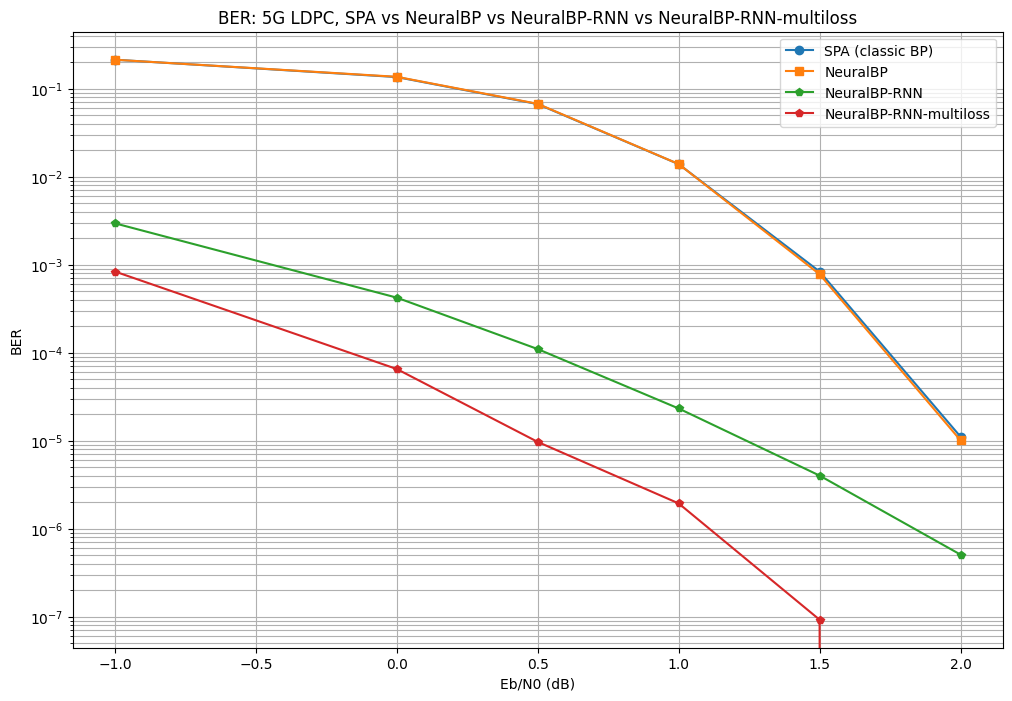

In [49]:
plt.figure(figsize=(12, 8))
plt.semilogy(ebn0_db_list, ber_spa_5g, marker='o', label='SPA (classic BP)')
plt.semilogy(ebn0_db_list, ber_nn_5g, marker='s', label='NeuralBP')
plt.semilogy(ebn0_db_list, ber_rnn_singleloss_5g, marker='p', label='NeuralBP-RNN')
plt.semilogy(ebn0_db_list, ber_rnn_5g, marker='p', label='NeuralBP-RNN-multiloss')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER: 5G LDPC, SPA vs NeuralBP vs NeuralBP-RNN vs NeuralBP-RNN-multiloss')
plt.show()


# 7. Подсчёт Frame Error Rate

In [34]:
@torch.no_grad()
def simulate_fer_model_batch(
    H, model,
    ebn0_db_list,
    num_frames=5000,
    batch_size=256,
    device=None,
    verbose=True
):
    if device is None:
        device = next(model.parameters()).device

    m, n = H.shape
    R = estimate_rate_from_H(H)

    model.eval()
    fer_list = []

    for ebn0_db in ebn0_db_list:
        sigma = ebn0_db_to_sigma(float(ebn0_db), R)

        err_frames = 0
        done = 0

        while done < num_frames:
            B = min(batch_size, num_frames - done)

            llr = generate_llr_batch(n, B, sigma).to(device)
            L_post = model(llr)
            bits_hat = (L_post < 0).int()

            frame_err = (bits_hat.sum(dim=1) > 0)
            err_frames += int(frame_err.sum().item())
            done += B

        fer = err_frames / num_frames
        fer_list.append(fer)

        if verbose:
            print(f"[MODEL] Eb/N0={ebn0_db:.2f} | FER={fer:.3e} | err_frames={err_frames}/{num_frames}")

    return np.array(fer_list)


In [35]:
@torch.no_grad()
def simulate_fer_spa_batch(
    H,
    ebn0_db_list,
    spa_max_iter=10,
    num_frames=5000,
    batch_size=256,
    clip=20.0,
    device=None,
    verbose=True
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    m, n = H.shape
    R = estimate_rate_from_H(H)

    c_idx, v_idx = np.where(H == 1)
    E = len(c_idx)
    c = torch.tensor(c_idx, dtype=torch.long, device=device)
    v = torch.tensor(v_idx, dtype=torch.long, device=device)

    fer_list = []

    for ebn0_db in ebn0_db_list:
        sigma = ebn0_db_to_sigma(float(ebn0_db), R)

        err_frames = 0
        done = 0

        while done < num_frames:
            B = min(batch_size, num_frames - done)

            llr = generate_llr_batch(n, B, sigma).to(device)
            L_post = spa_decode_batch_edges(
                llr, m=m, n=n, E=E, c=c, v=v,
                max_iter=spa_max_iter, clip=clip
            )

            bits_hat = (L_post < 0).int()
            frame_err = (bits_hat.sum(dim=1) > 0)  # (B,)
            err_frames += int(frame_err.sum().item())
            done += B

        fer = err_frames / num_frames
        fer_list.append(fer)

        if verbose:
            print(f"[SPA] Eb/N0={ebn0_db:.2f} | FER={fer:.3e} | err_frames={err_frames}/{num_frames}")

    return np.array(fer_list)


In [45]:
import matplotlib.pyplot as plt
import numpy as np

ebn0_db_list = [-1.0, 0.0, 0.5, 1.0, 1.5, 2.0]
num_frames = 5000
batch_size = 256
spa_iters = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fer_spa = simulate_fer_spa_batch(
    H_5g, ebn0_db_list,
    spa_max_iter=spa_iters,
    num_frames=num_frames,
    batch_size=batch_size,
    device=device
)

fer_neuralbp = simulate_fer_model_batch(
    H_5g, trained_neural_bp_5g,
    ebn0_db_list,
    num_frames=num_frames,
    batch_size=batch_size,
    device=device
)

fer_rnn = simulate_fer_model_batch(
    H_5g, model_rnn_singleloss,
    ebn0_db_list,
    num_frames=num_frames,
    batch_size=batch_size,
    device=device
)
fer_rnn_multiloss = simulate_fer_model_batch(
    H_5g, model_rnn,
    ebn0_db_list,
    num_frames=num_frames,
    batch_size=batch_size,
    device=device
)
# чтобы log не ломался на нулях
eps = 0.5 / num_frames
fer_spa_p = np.maximum(fer_spa, eps)
fer_nn_p  = np.maximum(fer_neuralbp, eps)
fer_rnn_p = np.maximum(fer_rnn, eps)




[SPA] Eb/N0=-1.00 | FER=1.000e+00 | err_frames=5000/5000
[SPA] Eb/N0=0.00 | FER=1.000e+00 | err_frames=5000/5000
[SPA] Eb/N0=0.50 | FER=9.766e-01 | err_frames=4883/5000
[SPA] Eb/N0=1.00 | FER=5.938e-01 | err_frames=2969/5000
[SPA] Eb/N0=1.50 | FER=9.600e-02 | err_frames=480/5000
[SPA] Eb/N0=2.00 | FER=3.000e-03 | err_frames=15/5000
[MODEL] Eb/N0=-1.00 | FER=1.000e+00 | err_frames=5000/5000
[MODEL] Eb/N0=0.00 | FER=9.998e-01 | err_frames=4999/5000
[MODEL] Eb/N0=0.50 | FER=9.808e-01 | err_frames=4904/5000
[MODEL] Eb/N0=1.00 | FER=6.270e-01 | err_frames=3135/5000
[MODEL] Eb/N0=1.50 | FER=9.720e-02 | err_frames=486/5000
[MODEL] Eb/N0=2.00 | FER=3.800e-03 | err_frames=19/5000
[MODEL] Eb/N0=-1.00 | FER=8.000e-01 | err_frames=4000/5000
[MODEL] Eb/N0=0.00 | FER=2.314e-01 | err_frames=1157/5000
[MODEL] Eb/N0=0.50 | FER=6.960e-02 | err_frames=348/5000
[MODEL] Eb/N0=1.00 | FER=1.520e-02 | err_frames=76/5000
[MODEL] Eb/N0=1.50 | FER=2.600e-03 | err_frames=13/5000
[MODEL] Eb/N0=2.00 | FER=6.000e-04

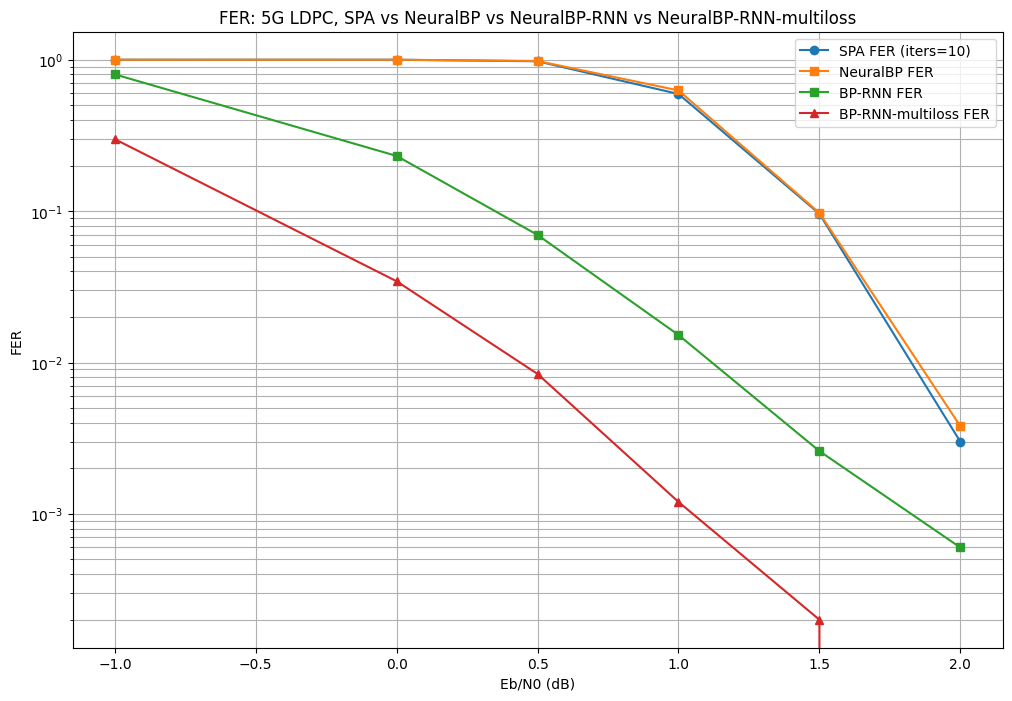

In [50]:
plt.figure(figsize=(12,8))
plt.semilogy(ebn0_db_list, fer_spa_p, marker='o', label=f'SPA FER (iters={spa_iters})')
plt.semilogy(ebn0_db_list, fer_nn_p,  marker='s', label='NeuralBP FER')
plt.semilogy(ebn0_db_list, fer_rnn_p,  marker='s', label='BP-RNN FER')
plt.semilogy(ebn0_db_list, fer_rnn_multiloss, marker='^', label='BP-RNN-multiloss FER')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('FER')
plt.title('FER: 5G LDPC, SPA vs NeuralBP vs NeuralBP-RNN vs NeuralBP-RNN-multiloss')
plt.grid(True, which='both')
plt.legend()
plt.show()